# QTW Lab 12

## David Josephs, Andy Heroy, Carson Drake, Che' Cobb


# Introduction

This case study has set its sights on neural networks.  Specifically focused on high energy physics of Higgs Bosons!  An exciting field in physics that deals with very fast, high energy collisions that quickly decay into other particles.  These exotic Higgs Bosons form and decay so quickly that they can't be directly observed, but the decayed product particles vector and momentum can be measured.  Our task is to recreate the deep neural network used by P. Baldi et all and try to improve upon the models performance by implementing modern machine learning tools that have been developed since the release of this paper. 

# Background

The dataset created by P. Baldi et all consists of 11 million records of high energy collisions with 21 observable features and 7 manufactured features that aide physicists to classify the type of resulting particles.  After careful examination of the paper we deduced the following parameters to have been used in creation of their model.  

- Neurons = 300 per Layer
- Number of Layers = 5 Layers
- Normalization - 0 to 1
- Activation Function = tanh for the hidden layers, sigmoid for the output layer
- Learning Rate = 0.05
- Learning Rate Decay = 1e-5, 
- Momentum = 0.9, increase linearly to 0.99 for 200 epochs
- Metrics = AUC, Accuracy
- Epoch's = 1000
- Batch Size = 100
- Initialization = Random normal, all with mean 0, std deviation:
  - bottom (input) layer: 0.1
  - hidden layers: 0.05
  - top (output) layer: 0.001




In [0]:
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


# from google.colab import files
# uploaded = files.upload()
print(tf.__version__)


1 Physical GPUs, 1 Logical GPUs
2.2.0-rc1


# Analysis

## Baseline Model Replication
Next, we input the parameters described above into action in order to rebuild P. Baldi et all's deep neural network.  We import the directly from the [UCI repository.](https://archive.ics.uci.edu/ml/datasets/HIGGS#) and create some basic histograms see what type of ranges our features exhibit.  To avoid overplotting and RAM issues, we sample the first 100k rows of the dataset


In [0]:
#Importing dataset.  
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'
col_names = ['Target','lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 
             'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 
             'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
full_higgs_df = pd.read_csv(url, header=None, names=col_names)


In [0]:
full_higgs_df.head(5)

,Target,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [0]:
#Taking the first 100k rows for faster analysis run times. 

small_higgs_df = pd.DataFrame(full_higgs_df.iloc[0:100000])
X = small_higgs_df.drop('Target', axis=1)
y = small_higgs_df.iloc[:,0]

print(X.shape)
print(y.shape)

#should probably run it through the standard scaler as well.  
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)


(100000, 28)
(100000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases l

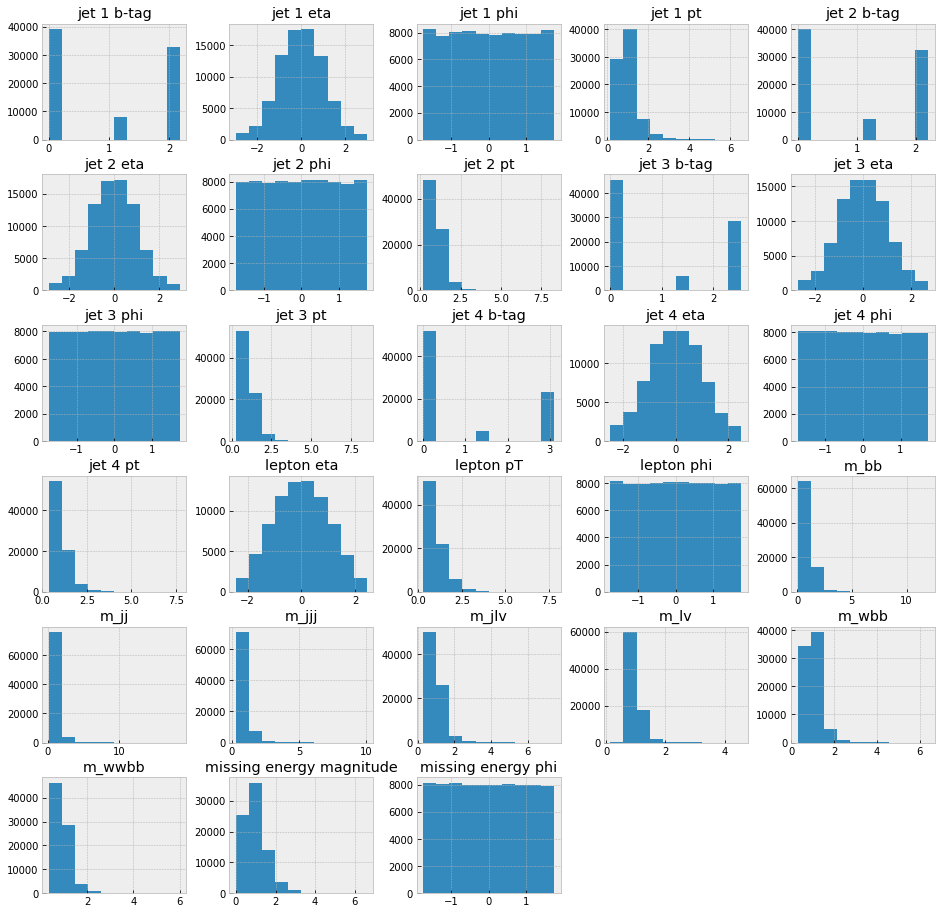

In [0]:
#Plotting some EDA/hist of variables the variables. 

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (16,16))
ax = fig.gca()
X_train.hist(ax=ax)
plt.title("Histogram of the data")
plt.show()


**Figure 1**: histogram of all the features of the data, looking particularly for any strange outliers. The data looks more or less safe

### Building the model

First, we construct the basic architecture of the model. We initialize just as in the paper, using the `weird_initializer` function.

In [0]:
#Lets build that 5 layer dip!

def weird_initializer(i: int) -> tf.keras.initializers.Initializer:
  if i == 0:
    return tf.keras.initializers.RandomNormal(0,0.1)
  else: 
    return tf.keras.initializers.RandomNormal(0, 0.05)

model = tf.keras.Sequential()
hidden = [{'units': 300, 'activation': 'tanh', 'kernel_initializer': weird_initializer(i)} for i in range(5)]
for h in hidden:
  model.add(layers.Dense(**h))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.001)))


Next, we create training and test sets, using scikit learns train test split function. We cast the data to `np.float16` to save memory and make the code run faster on GPU. Note that we now switch back **to using the full dataset**.

In [0]:
# use all the data!
X = full_higgs_df.drop('Target', axis=1).values.astype(np.float16)
y = np.asarray(full_higgs_df['Target']).astype(np.float16)

del full_higgs_df
import gc; gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)


For further speed gain, it is important to use a `generator` class with tensorflow, in order to load data onto the gpu in parallel. We also further split the training data into training and validation sets, and construct generators

In [0]:
from typing import Tuple


# generator class! With type hints because we are losers!
class generator(tf.keras.utils.Sequence):
  def __init__(self, X: np.ndarray, y: np.ndarray, batch_size: int=100, shuffle: bool=True) -> None:
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.X = X
    self.y = y
    self.on_epoch_end()
  
  def __len__(self) -> int:
    return self.X.shape[0] // self.batch_size

  def on_epoch_end(self) -> None:
    self.indexes = np.arange(self.X.shape[0])
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    return self.X[indexes, :], self.y[indexes]


# train-val-test split is important for parameter tuning
X_train2, X_val, y_train2, y_val = train_test_split(X_train,y_train, test_size=0.20, random_state = 42)


# construct generators
train = generator(X_train2, y_train2)
val = generator(X_val, y_val)
test = generator(X_test, y_test)

The momentum and learning rate schedule defined in the paper are rather hard to reproduce with pure keras code. Therefore, we construct a custom callback which matches the paper exactly

In [0]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K


class LR_Moment_scheduler(Callback):
    """Callback to schedule learning rate and momentum exactly the same as in the paper
    """

    def __init__(self, eta_max: float, eta_min:float =1e-6, verbose: int=0, epoch_momentum:int=200, 
                 decay: float= 1e-5, momentum_min: float=0.9, momentum_max: float=0.99) -> None:
        super().__init__()
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
        self.decay = decay
        self.momentum_max = momentum_max
        self.momentum_min = momentum_min
        self.moment_slope = (momentum_max - momentum_min) / epoch_momentum
  

    def on_epoch_begin(self, epoch, logs=None):
        # dont break code!
        if not hasattr(self.model.optimizer, 'learning_rate') or not hasattr(self.model.optimizer, 'momentum'):
          raise ValueError('Optimizer must have a "learning_rate"  and "momentum" attribute.')
        
        # decay learning rate, with a minumum
        # this is exactly how keras decayes
        lr = self.eta_max * 1/(1+ self.decay*epoch)
        if lr < self.eta_min:
          # need to make sure it doesnt just go all the way to zero
          lr = self.eta_min
        K.set_value(self.model.optimizer.learning_rate, lr)
        
        # increase momentum, with a maximum
        # linearly increasing, just as in paper
        momentum = self.momentum_min + epoch*self.moment_slope
        if momentum > self.momentum_max:
          momentum = self.momentum_max
        K.set_value(self.model.optimizer.momentum, momentum)

        if self.verbose > 0:
          print('\nEpoch %05d: scheduler setting learning '
                  'rate to %s., momentum to %s' % (epoch + 1, lr, momentum))


    def on_epoch_end(self, epoch, logs=None):
        # so we can view the callback in our history object
        logs = logs or {}
        logs['learning_rate'] = K.get_value(self.model.optimizer.learning_rate)
        logs['momentum'] = K.get_value(self.model.optimizer.momentum)



Finally, it is time to compile and fit the model. We chose to use nesterov momentum instead of normal momentum, because it got us results which were closer to the paper. The paper also mentions that they used early stopping, with a patience of 10 epochs and a threshold of 0.00001. After experimentation, we decided it was not worth the time expended to wait for momentum to reach its peak after 200 epochs (page 9), as there was little improvement after 50 or so epochs. Thus, we allow early stopping in all phases of training. Finally, to conserve time, we sample the training and validation sets on each epoch, sampling 5% of the training set and 20% of the validation set each epoch (hopefully covering the entire training set every 20 epochs).

In [0]:
optimiz = tf.keras.optimizers.SGD(learning_rate=0.05,
                                  momentum=0.95, nesterov=True)
schedule = LR_Moment_scheduler(0.05, verbose=1)


check = tf.keras.callbacks.ModelCheckpoint(
    "recreate.h5", monitor="val_loss", save_best_only=True
)

# first we go with no stopping for 200 epochs
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10)
model.compile(optimizer=optimiz,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train, validation_data = val, epochs=200, steps_per_epoch = len(train)//20,
          validation_steps = len(val) // 5 , callbacks = [schedule, stopper, check])


Epoch 00001: scheduler setting learning rate to 0.05., momentum to 0.9
Epoch 1/200
3520/3520 [==============================] - 18s 5ms/step - loss: 0.6175 - accuracy: 0.6535 - val_loss: 0.5912 - val_accuracy: 0.6805 - learning_rate: 0.0500 - momentum: 0.9000

Epoch 00002: scheduler setting learning rate to 0.04999950000499995., momentum to 0.90045
Epoch 2/200
3520/3520 [==============================] - 18s 5ms/step - loss: 0.5846 - accuracy: 0.6885 - val_loss: 0.5710 - val_accuracy: 0.6982 - learning_rate: 0.0500 - momentum: 0.9004

Epoch 00003: scheduler setting learning rate to 0.04999900001999961., momentum to 0.9009
Epoch 3/200
3520/3520 [==============================] - 19s 5ms/step - loss: 0.5693 - accuracy: 0.7003 - val_loss: 0.5704 - val_accuracy: 0.7030 - learning_rate: 0.0500 - momentum: 0.9009

Epoch 00004: scheduler setting learning rate to 0.04999850004499865., momentum to 0.90135
Epoch 4/200
3520/3520 [==============================] - 18s 5ms/step - loss: 0.5600 - ac

Lets check out how we did! In the paper, they got an overall AUC of 0.885 with their 5 layer network.

In [0]:
from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, model.predict(X_test)))

AUC: 0.835902971532381


Looks like we got pretty close! If we were to take the time to not sample the training and test sets, and wait the full 200 epochs for momentum to peak, we could probably get very similar results. Lets check out what our training looked like now:

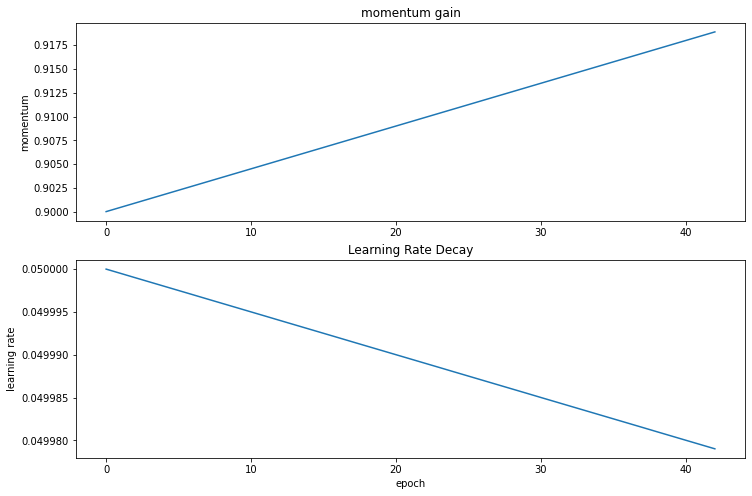

In [0]:
plt.subplot(212)
plt.plot(history.history['learning_rate'])
plt.title('Learning Rate Decay')
plt.ylabel('learning rate')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(211)
plt.plot(history.history['momentum'])
plt.title('momentum gain')
plt.ylabel('momentum')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2)
plt.show()

**Figure 2**: Momentum gain and learning rate decay over epochs. This is in line with what was mentioned with the paper

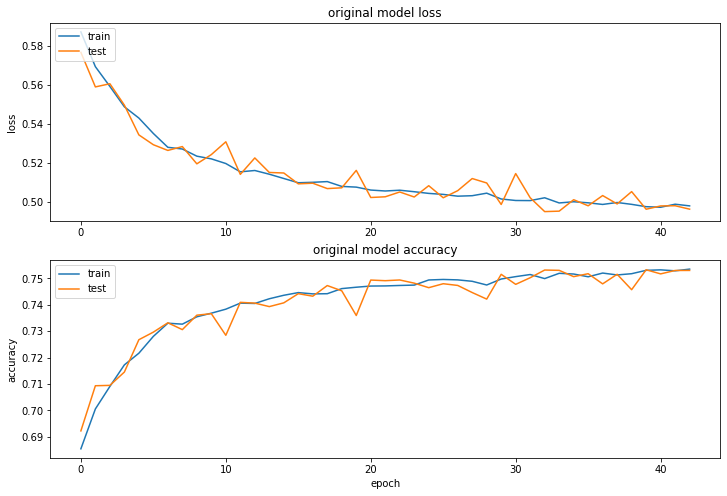

In [0]:
plt.subplot(212)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('original model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('original model loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2)
plt.show()

**Figure 3**: Training history. Note the instability of both the training and testing, but also note that they both seem to flatten out and bounce around at the end. Probably, a steeper decay rate for learning rate could solve this

## Improving on the Baseline model
We propose the following improvements on the baseline model:

- Modern activation function:
  - Instead of tanh, which has a tendency to saturate and stop learning very quickly, or relu, which has the dead neuron problem, we use the recent activation function, Mish. ([source](https://arxiv.org/abs/1908.08681))
- Modern optimization:
  - Instead of SGD (which takes forever) or Adam (which suffers from the cold start problem and takes a bit longer to train), we use a combination of [Lookahead](https://arxiv.org/abs/1907.08610), which searches for other directions to optimize in based off the weights of a secondary optimizer, and [Rectified Adam](https://arxiv.org/abs/1908.03265v1), which solves the cold start problem of Adam
- Training schedule
  - We propose a delayed cosine annealing learning rate schedule. For the first few epochs, the model is conditioned on a high learning rate, which [allows it to converge to a more generalizable optima](https://arxiv.org/abs/2002.09572), and then the learning rate is rapidly annealed, in order to rectify the issues discussed in **Figure 3**.
- Architecture
  - For regularized activation functions like Relu and Mish, we must worry about the problem of dead neurons. Dead neurons are more likely in networks where all layers are the same width, and can be [alleviated by increasing the width of the network](https://arxiv.org/abs/1903.06733). Therefore, we start at a smaller number of hidden nodes and expand the network until it reaches 300 nodes on the top hidden layer

- Initialization
  - With the incredibly fast learning of this setup, large, random normal initializations as in the baseline model lead to exploding gradients. Thus, we choose to use the default orthoganal initialization in tensorflow for all layers, He or Glorot uniform.

- Learning rate
  - This setup learns much faster, and thus requires a lower learning rate than that implemented in the baseline model. We start at 1e-3, and anneal to 1e-6.

### Model Building

The mish activation function is pictured in the plot below:

Text(0.5, 1.0, 'Mish activation function')

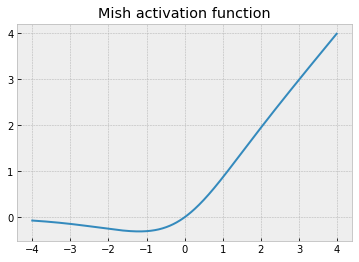

In [0]:
import matplotlib.pyplot as plt
import math
import numpy as np

def softplus(x):
  return np.log(1+ np.exp(x))

def mish(x):
  return x*(np.tanh(softplus(x)))

x = np.arange(-4,4, step=0.01)

plt.style.use('bmh')
plt.plot(x, mish(x))
plt.title("Mish activation function")

**Figure 4**: The Mish activation function.

This looks very similar to relu, however it is different because of the little wiggle in the negative half. The reason relu works so well, is the flatness in the negative half regularizes the network nicely, while the lack of constraint on the positive half allows it to learn for longer. The little wiggle on the negative half of mish means the network is less regularized, and learns faster, while still retaining the rest of Relu's nice properties


We now implement Mish in Keras, build the network, implement the combination of Lookahead and Rectified Adam (known as the [Ranger Optimizer](https://medium.com/@lessw/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d)), and compile the network

In [0]:
# Now lets improve using modern activations and optimization!
import tensorflow_addons as tfa
import math
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Layer

class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()))

    def compute_output_shape(self, input_shape):
            return input_shape



model2 = tf.keras.Sequential()
# networks should be expanding, this avoids dead neurons (find citation)
units = [100, 147, 200, 250, 300]
hidden = [{'units': units[i], 'activation': Mish()} for i in range(5)]
for h in hidden:
  model2.add(layers.Dense(**h))
#model.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation = 'sigmoid'))


def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    """
        function returning a tf.keras.optimizers.Optimizer object
        returned optimizer is a Ranger optimizer
        Ranger is an optimizer combining RAdam (https://arxiv.org/abs/1908.03265) and Lookahead (https://arxiv.org/abs/1907.0861)
        returned optimizer can be fed into the model.compile method of a tf.keras model as an optimizer
        ...
        Attributes
        ----------
        learning_rate : float
            step size to take for RAdam optimizer (depending on gradient)
        beta_1 : float
            parameter that specifies the exponentially moving average length for momentum (0<=beta_1<=1)
        beta_2 : float
            parameter that specifies the exponentially moving average length for variance (0<=beta_2<=1)
        epsilon : float
            small number to cause stability for variance division
        weight_decay : float
            number with which the weights of the model are multiplied each iteration (0<=weight_decay<=1)
        amsgrad : bool
            parameter that specifies whether to use amsgrad version of Adam (https://arxiv.org/abs/1904.03590)
        total_steps : int
            total number of training steps
        warmup_proportion : float
            the proportion of updated over which the learning rate is increased from min learning rate to learning rate (0<=warmup_proportion<=1)
        min_lr : float
            learning rate at which the optimizer starts
        k : int
            parameter that specifies after how many steps the lookahead step backwards should be applied
        alpha : float
            parameter that specifies how much in the direction of the fast weights should be moved (0<=alpha<=1)
    """
    # create RAdam optimizer
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    # feed RAdam optimizer into lookahead operation
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim

optim = Ranger(learning_rate = 1e-3)
model2.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])


Next we implement our learning rate scheduler, which first maintains a high learning rate for a set number of epochs, then cosine anneals them to a minimum. There are a number of further options, for cyclical, decayed learning (this was implemented as a part of the author's capstone project), but they are not relevant here.

In [0]:
from tensorflow.keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0, epoch_start=80, restart_epochs=None, gamma=1, expansion=1, flat_end = False):
        super(CosineAnnealingScheduler, self).__init__()
        self.epoch_start=epoch_start
        self.expansion=expansion
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
        self.restart_epochs = restart_epochs
        self.gamma = gamma
        self.flat_end = flat_end

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'learning_rate'):
            raise ValueError('Optimizer must have a "learning_rate" attribute.')
        if epoch > self.epoch_start - 1:
            if self.restart_epochs is None:
                learning_rate = self.eta_min + (self.eta_max*self.gamma - self.eta_min) * (1 + math.cos(math.pi * (epoch - self.epoch_start) / self.T_max)) / 2
                K.set_value(self.model.optimizer.learning_rate, learning_rate)
            else:
                learning_rate = self.eta_min + (self.eta_max*self.gamma - self.eta_min) * (1 + math.cos(math.pi * ((epoch  % (self.restart_epochs+self.epoch_start)) - self.epoch_start) / self.T_max)) / 2
                K.set_value(self.model.optimizer.learning_rate, learning_rate)
            if learning_rate<=self.eta_min:
                self.eta_max *= self.gamma
                self.T_max *=self.expansion
        if self.flat_end and epoch >= ((self.epoch_start -1 ) + T_max):
            learning_rate = self.eta_min

        else:
            learning_rate=self.model.optimizer.learning_rate
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, learning_rate))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['learning_rate'] = K.get_value(self.model.optimizer.learning_rate)



Now we fit the model:

In [0]:
schedule = CosineAnnealingScheduler(T_max=50, eta_max=1e-3, eta_min=1e-5, verbose=1, epoch_start=5)

# note the per epoch sampling again!
history2 = model2.fit(train, validation_data = val, epochs=55, steps_per_epoch = len(train)//20,
          validation_steps = len(val) // 5 , callbacks = [schedule])




Epoch 00001: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>.
Epoch 1/55
3520/3520 [==============================] - 45s 13ms/step - loss: 0.6289 - accuracy: 0.6399 - val_loss: 0.5963 - val_accuracy: 0.6774 - learning_rate: 0.0010

Epoch 00002: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>.
Epoch 2/55
3520/3520 [==============================] - 45s 13ms/step - loss: 0.5891 - accuracy: 0.6824 - val_loss: 0.5826 - val_accuracy: 0.6896 - learning_rate: 0.0010

Epoch 00003: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>.
Epoch 3/55
3520/3520 [==============================] - 46s 13ms/step - loss: 0.5717 - accuracy: 0.6984 - val_loss: 0.5603 - val_accuracy: 0.7064 - learning_rate: 0.0010

Epoch 00004: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate

Lets check out how we did:

In [0]:
print("AUC:", roc_auc_score(y_test,  model2.predict(X_test)))

AUC: 0.856588915374834


A significant improvement! We are incredibly close to the AUC achieved in the paper (0.885). If we spent more time training, and didnt sample the training dataset, we could absolutely come very very close. Lets visualize our trainig now:

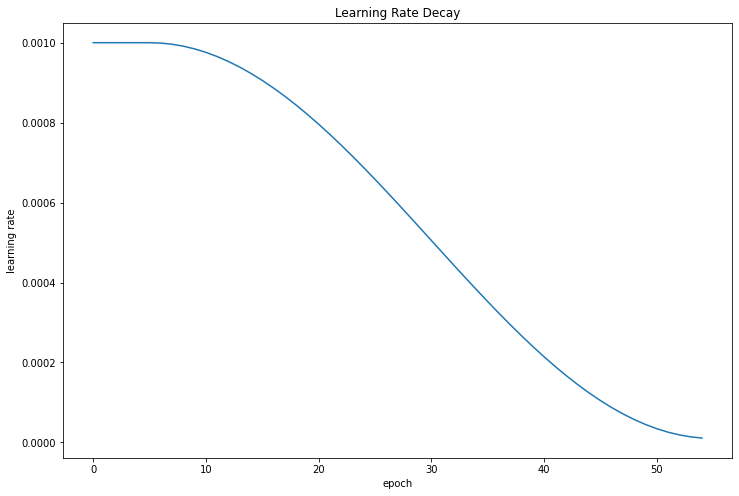

In [0]:

plt.plot(history2.history['learning_rate'])
plt.title('Learning Rate Decay')
plt.ylabel('learning rate')
plt.xlabel('epoch')
# summarize history for loss
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2)
plt.show()

**Figure 5**: The delayed cosine annealing rate schedule. After 5 epochs, the learning rate is annealed following a cosine pattern.

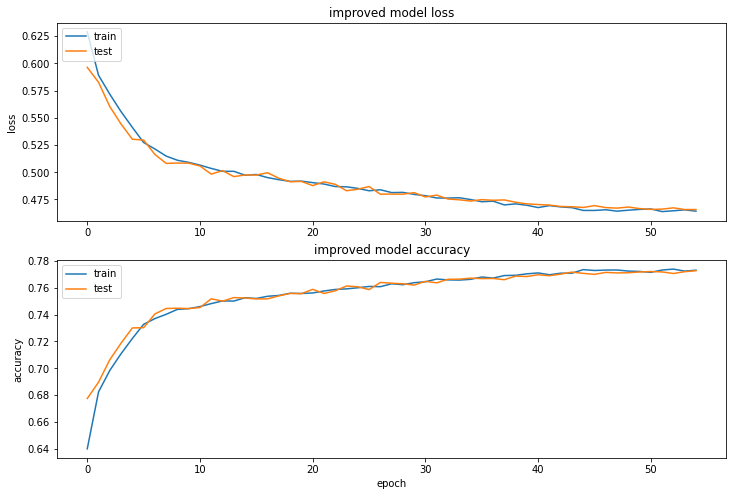

In [0]:
plt.subplot(212)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('improved model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(211)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('improved model loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2)
plt.show()

**Figure 6**: Training history. The improved model continues to decrease and is slightly more stable than the baseline model.




# Discussion of Results

We were able to improve upon the baseline model significantly, with a much smaller network, by using modern advancements in deep learning. With more time for fiddling with the architecture, and a bigger computer for fitting the entire dataset, we could likely achieve equal if not better results than the original paper. 